In [ ]:
# Charger packages et clé openweather depuis .env
import pandas as pd
import requests
import time
from tqdm import tqdm
import os
from dotenv import load_dotenv

# Charger les variables d'environnement
load_dotenv('../config/.env')
API_KEY = os.getenv('OPENWEATHER_API_KEY')

# Vérifier que la clé API est chargée
if not API_KEY:
    raise ValueError("❌ OPENWEATHER_API_KEY non trouvée dans .env")
else:
    print(f"✅ Clé API chargée : {API_KEY[:10]}...")

✅ Clé API chargée : fe52aa81bf...


In [8]:
# Charger les coordonnées des villes
df_cities = pd.read_csv('../data/raw/cities_coordinates.csv')
print(f"\n📍 {len(df_cities)} villes chargées")
df_cities.head()


📍 35 villes chargées


,city_id,city,latitude,longitude,display_name
0,1,Mont Saint Michel,48.635954,-1.511460,"Mont Saint-Michel, Le Mont-Saint-Michel, Avran..."
1,2,St Malo,48.649518,-2.026041,"Saint-Malo, Ille-et-Vilaine, Bretagne, France ..."
2,3,Bayeux,49.276462,-0.702474,"Bayeux, Calvados, Normandie, France métropolit..."
3,4,Le Havre,49.493898,0.107973,"Le Havre, Seine-Maritime, Normandie, France mé..."
4,5,Rouen,49.440459,1.093966,"Rouen, Seine-Maritime, Normandie, France métro..."


In [14]:
# Fonction pour récupérer la météo d'une ville

def get_weather_forecast(city_name, latitude, longitude, api_key):
    """
    Récupère les prévisions météo sur 5 jours avec l'API gratuite.
    
    Args:
        city_name (str): Nom de la ville
        latitude (float): Latitude
        longitude (float): Longitude
        api_key (str): Clé API OpenWeatherMap
        
    Returns:
        list: Liste de dictionnaires avec les prévisions par jour
    """
    # API GRATUITE : 5 day / 3 hour forecast
    url = "https://api.openweathermap.org/data/2.5/forecast"
    
    params = {
        'lat': latitude,
        'lon': longitude,
        'appid': api_key,
        'units': 'metric',
        'lang': 'fr'
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()
        forecasts = data.get('list', [])
        
        # Regrouper par jour
        daily_data = {}
        
        for item in forecasts:
            # Extraire la date (sans l'heure)
            date = pd.to_datetime(item['dt'], unit='s').strftime('%Y-%m-%d')
            
            if date not in daily_data:
                daily_data[date] = {
                    'temps': [],
                    'humidity': [],
                    'pop': [],
                    'rain': [],
                    'wind_speed': [],
                    'clouds': [],
                    'descriptions': []
                }
            
            # Accumuler les données de la journée
            daily_data[date]['temps'].append(item['main']['temp'])
            daily_data[date]['humidity'].append(item['main']['humidity'])
            daily_data[date]['pop'].append(item.get('pop', 0) * 100)
            daily_data[date]['rain'].append(item.get('rain', {}).get('3h', 0))
            daily_data[date]['wind_speed'].append(item['wind']['speed'])
            daily_data[date]['clouds'].append(item['clouds']['all'])
            daily_data[date]['descriptions'].append(item['weather'][0]['description'])
        
        # Créer le résultat final (moyennes par jour)
        weather_data = []
        
        for day_index, (date, values) in enumerate(list(daily_data.items())[:7], start=1):
            temps = values['temps']
            
            weather_info = {
                'city': city_name,
                'day': day_index,
                'date': date,
                'temp_min': min(temps),
                'temp_max': max(temps),
                'temp_avg': sum(temps) / len(temps),
                'humidity': sum(values['humidity']) / len(values['humidity']),
                'pop': max(values['pop']),  # Probabilité max de pluie dans la journée
                'rain': sum(values['rain']),  # Total de pluie dans la journée
                'wind_speed': sum(values['wind_speed']) / len(values['wind_speed']),
                'clouds': sum(values['clouds']) / len(values['clouds']),
                'weather_description': values['descriptions'][len(values['descriptions'])//2]  # Description du milieu de journée
            }
            weather_data.append(weather_info)
        
        return weather_data
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Erreur API pour {city_name}: {e}")
        return []
    except (KeyError, IndexError) as e:
        print(f"❌ Erreur de données pour {city_name}: {e}")
        return []

In [15]:
# Test sur Paris
test_paris = df_cities[df_cities['city'] == 'Paris'].iloc[0]

weather_paris = get_weather_forecast(
    city_name=test_paris['city'],
    latitude=test_paris['latitude'],
    longitude=test_paris['longitude'],
    api_key=API_KEY
)

if weather_paris:
    print(f"\n✅ Prévisions pour {test_paris['city']} :")
    for day in weather_paris:
        print(f"  Jour {day['day']} ({day['date']}) : {day['temp_min']:.1f}°C - {day['temp_max']:.1f}°C, "
              f"Pluie: {day['pop']:.0f}%, {day['weather_description']}")
else:
    print("❌ Échec de la récupération")


✅ Prévisions pour Paris :
  Jour 1 (2025-11-07) : 13.3°C - 14.1°C, Pluie: 0%, couvert
  Jour 2 (2025-11-08) : 9.5°C - 14.7°C, Pluie: 20%, couvert
  Jour 3 (2025-11-09) : 10.4°C - 14.7°C, Pluie: 0%, partiellement nuageux
  Jour 4 (2025-11-10) : 9.0°C - 13.7°C, Pluie: 100%, couvert
  Jour 5 (2025-11-11) : 9.3°C - 12.8°C, Pluie: 0%, couvert
  Jour 6 (2025-11-12) : 9.5°C - 15.4°C, Pluie: 0%, couvert


In [ ]:
# Boucler sur toutes les villes

# Liste pour stocker toutes les données météo
all_weather_data = []

print("🌦️ Récupération des données météo...\n")

# Boucle sur chaque ville avec barre de progression
for index, row in tqdm(df_cities.iterrows(), total=len(df_cities), desc="Météo"):
    # Récupérer les prévisions
    weather = get_weather_forecast(
        city_name=row['city'],
        latitude=row['latitude'],
        longitude=row['longitude'],
        api_key=API_KEY
    )
    
    # Ajouter à la liste
    all_weather_data.extend(weather)
    
    # ⚠️ IMPORTANT : Pause pour respecter les limites de l'API
    # API gratuite : 60 appels/minute
    time.sleep(1)

print(f"\n✅ Données météo récupérées !")
print(f"📊 Nombre total d'enregistrements : {len(all_weather_data)} (35 villes × 6 jours)")

🌦️ Récupération des données météo...



Météo: 100%|██████████| 35/35 [00:45<00:00,  1.31s/it]


✅ Données météo récupérées !
📊 Nombre total d'enregistrements : 210 (35 villes × 7 jours)


In [20]:
# Convertir en DataFrame

# Créer le DataFrame
df_weather = pd.DataFrame(all_weather_data)

# Afficher les premières lignes
print("\n📊 Aperçu des données météo :")
display(df_weather.head(10))

# Statistiques
print("\n📈 Statistiques des données :")
print(df_weather[['temp_min', 'temp_max', 'pop', 'rain', 'humidity']].describe())


📊 Aperçu des données météo :


,city,day,date,temp_min,temp_max,temp_avg,humidity,pop,rain,wind_speed,clouds,weather_description
0,Mont Saint Michel,1,2025-11-07,12.51,13.23,12.936667,93.666667,100.0,2.22,5.41000,100.000,légère pluie
1,Mont Saint Michel,2,2025-11-08,9.96,14.74,11.681250,88.250000,76.0,0.16,3.27875,72.375,légère pluie
2,Mont Saint Michel,3,2025-11-09,7.31,15.09,11.020000,83.875000,0.0,0.00,4.65000,71.250,couvert
3,Mont Saint Michel,4,2025-11-10,9.58,14.17,11.975000,89.000000,100.0,11.55,5.80625,99.125,pluie modérée
4,Mont Saint Michel,5,2025-11-11,9.17,14.46,11.546250,89.375000,0.0,0.00,6.12625,97.125,couvert
5,Mont Saint Michel,6,2025-11-12,10.08,15.82,11.716000,76.800000,0.0,0.00,7.41400,93.600,couvert
6,St Malo,1,2025-11-07,12.69,13.61,13.196667,96.000000,100.0,1.87,5.74000,100.000,légère pluie
7,St Malo,2,2025-11-08,11.15,14.41,12.408750,83.875000,20.0,0.13,4.73750,69.375,nuageux
8,St Malo,3,2025-11-09,9.25,15.43,11.921250,83.125000,0.0,0.00,5.85000,72.250,couvert
9,St Malo,4,2025-11-10,10.74,14.70,12.983750,85.000000,100.0,8.64,6.60750,91.375,légère pluie



📈 Statistiques des données :
         temp_min    temp_max         pop        rain    humidity
count  210.000000  210.000000  210.000000  210.000000  210.000000
mean     9.441571   14.786762   19.771429    1.276095   77.854683
std      2.995134    2.498246   36.617447    4.583506    8.402742
min     -0.630000    2.600000    0.000000    0.000000   59.800000
25%      7.842500   13.517500    0.000000    0.000000   71.375000
50%      9.560000   15.055000    0.000000    0.000000   78.666667
75%     11.685000   16.187500   20.000000    0.110000   83.875000
max     15.080000   22.190000  100.000000   38.810000   96.000000


In [23]:
# Ajouter ID de la ville

# Fusionner avec df_cities pour récupérer city_id
df_weather = df_weather.merge(
    df_cities[['city', 'city_id', 'latitude', 'longitude']], 
    on='city', 
    how='left'
)

# Réorganiser UNIQUEMENT les colonnes qui existent
cols_order = [
    'city_id', 'city', 'latitude', 'longitude', 
    'day', 'date', 
    'temp_min', 'temp_max', 'temp_avg',
    'humidity', 'pop', 'rain', 
    'wind_speed', 'clouds',
    'weather_description'
]

# Vérifier que toutes ces colonnes existent avant de réorganiser
existing_cols = [col for col in cols_order if col in df_weather.columns]

df_weather = df_weather[existing_cols]

print("\n✅ DataFrame réorganisé")
display(df_weather.head())


✅ DataFrame réorganisé


,city_id,city,latitude,longitude,day,date,temp_min,temp_max,temp_avg,humidity,pop,rain,wind_speed,clouds,weather_description
0,1,Mont Saint Michel,48.635954,-1.51146,1,2025-11-07,12.51,13.23,12.936667,93.666667,100.0,2.22,5.41000,100.000,légère pluie
1,1,Mont Saint Michel,48.635954,-1.51146,2,2025-11-08,9.96,14.74,11.681250,88.250000,76.0,0.16,3.27875,72.375,légère pluie
2,1,Mont Saint Michel,48.635954,-1.51146,3,2025-11-09,7.31,15.09,11.020000,83.875000,0.0,0.00,4.65000,71.250,couvert
3,1,Mont Saint Michel,48.635954,-1.51146,4,2025-11-10,9.58,14.17,11.975000,89.000000,100.0,11.55,5.80625,99.125,pluie modérée
4,1,Mont Saint Michel,48.635954,-1.51146,5,2025-11-11,9.17,14.46,11.546250,89.375000,0.0,0.00,6.12625,97.125,couvert


In [26]:
# Sauvegarder le df complet

weather_csv_path = '../data/raw/weather_forecast_6days.csv'
df_weather.to_csv(weather_csv_path, index=False, encoding='utf-8')

print(f"\n✅ Données météo sauvegardées : {weather_csv_path}")
print(f"📁 Taille du fichier : {os.path.getsize(weather_csv_path)} bytes")
print(f"📊 Nombre de lignes : {len(df_weather)}")


✅ Données météo sauvegardées : ../data/raw/weather_forecast_6days.csv
📁 Taille du fichier : 24165 bytes
📊 Nombre de lignes : 210


In [27]:
# Vérifier qualité des données

# Vérifier les valeurs manquantes
print("\n🔍 Vérification des données manquantes :")
missing = df_weather.isnull().sum()
print(missing[missing > 0])

# Vérifier les villes couvertes
print(f"\n🌍 Nombre de villes avec données météo : {df_weather['city'].nunique()}")
print(f"📅 Nombre de jours de prévisions : {df_weather['day'].max()}")

# Vérifier les températures aberrantes
print("\n🌡️ Plage de températures :")
print(f"  Min : {df_weather['temp_min'].min():.1f}°C")
print(f"  Max : {df_weather['temp_max'].max():.1f}°C")


🔍 Vérification des données manquantes :
Series([], dtype: int64)

🌍 Nombre de villes avec données météo : 35
📅 Nombre de jours de prévisions : 6

🌡️ Plage de températures :
  Min : -0.6°C
  Max : 22.2°C


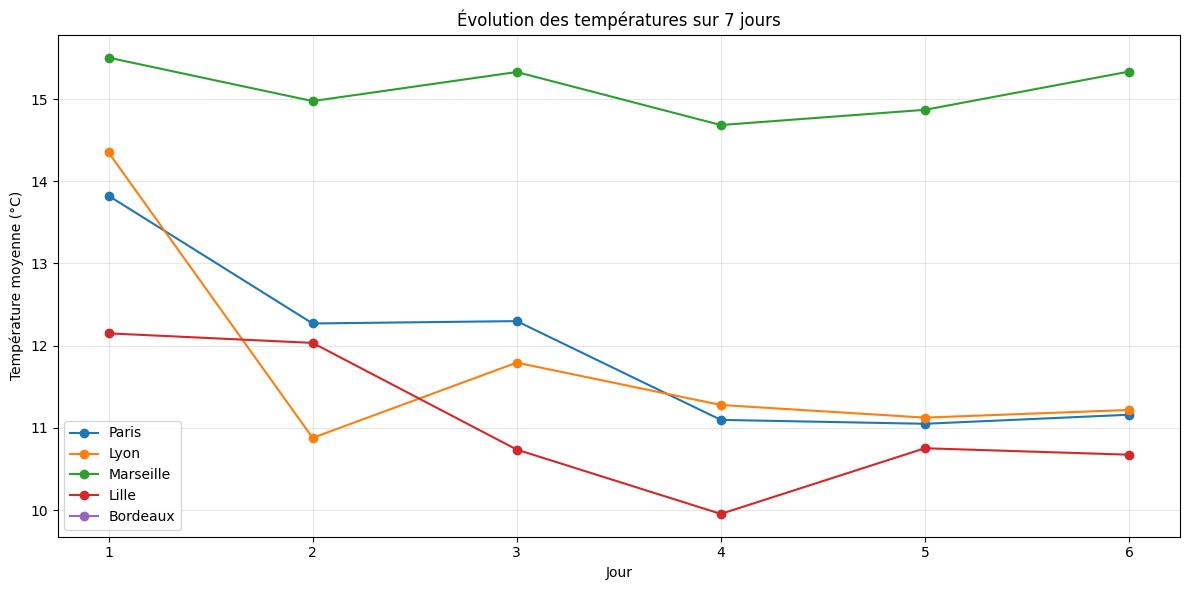

✅ Graphique sauvegardé : ../visualizations/temp_evolution.png


In [28]:
# Visualiser les données

import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner quelques villes pour la visualisation
sample_cities = ['Paris', 'Lyon', 'Marseille', 'Lille', 'Bordeaux']
df_sample = df_weather[df_weather['city'].isin(sample_cities)]

# Créer le graphique
plt.figure(figsize=(12, 6))
for city in sample_cities:
    city_data = df_sample[df_sample['city'] == city]
    plt.plot(city_data['day'], city_data['temp_avg'], marker='o', label=city)

plt.xlabel('Jour')
plt.ylabel('Température moyenne (°C)')
plt.title('Évolution des températures sur 7 jours')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/temp_evolution.png', dpi=150)
plt.show()

print("✅ Graphique sauvegardé : ../visualizations/temp_evolution.png")

In [ ]:
# Heatmap des probabilités de pluie

# Créer un pivot pour la heatmap
pivot_rain = df_weather.pivot_table(
    values='pop', 
    index='city', 
    columns='day', 
    aggfunc='mean'
)

# Créer la heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_rain, annot=False, cmap='Blues', cbar_kws={'label': 'Probabilité de pluie (%)'})
plt.title('Probabilité de pluie sur 7 jours par ville')
plt.xlabel('Jour')
plt.ylabel('Ville')
plt.tight_layout()
plt.savefig('../visualizations/rain_probability_heatmap.png', dpi=150)
plt.show()

print("✅ Heatmap sauvegardée : ../visualizations/rain_probability_heatmap.png")